# Classify fish species using transfer learning
## \# Class activation heatmap for image classification
## \# Grad-CAM class activation visualization

Having around 9.000 pictures of 9 different seafood types, the goal is to create a model to classify them.

<img src="https://i.imgur.com/L9aeCGo.png" style="width: 70%; height: 70%" align = "left">

# Table of contents

[<h3>1. Load and transform the dataset</h3>](#1)

[<h3>2. Display 15 pictures of the dataset</h3>](#2)

[<h3>3. Load the Images with a generator</h3>](#3)

[<h3>4. Train the model</h3>](#4)

[<h3>5. Visualize the result</h3>](#5)

[<h3>6. Class activation heatmap for image classification</h3>](#5)

# General Description about the dataset and its paper

*** A Large-Scale Dataset for Segmentation and Classification ***

Authors: O. Ulucan, D. Karakaya, M. Turkan
Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey
Corresponding author: M. Turkan


***General Introduction***

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, 
black sea sprat, striped red mullet, trout, shrimp image samples. 

If you use this dataset in your work, please consider to cite:

* O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)


***Purpose of the work***

This dataset was collected in order to carry out segmentation, feature extraction and classification tasks
and compare the common segmentation, feature extraction and classification algortihms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features).
All of the experiment results prove the usability of our dataset for purposes mentioned above.



***Data Gathering Equipment and Data Augmentation***

Images were collected via 2 different cameras, Kodak Easyshare Z650 and Samsung ST60. 
Therefore, the resolution of the images are 2832 x 2128, 1024 x 768, respectively.

Before the segmentation, feature extraction and classification process, the dataset was resized to 590 x 445
by preserving the aspect ratio. After resizing the images, all labels in the dataset were augmented (by flipping and rotating). 

At the end of the augmentation process, the number of total images for each class became 2000; 1000 for the RGB fish images
and 1000 for their pair-wise ground truth labels. 



***Description of the data in this data set***

The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-waise augmented ground truths.
Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".
 
For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT".

# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [77]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [78]:
image_dir = Path('Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

print(image_df.head())

# Xuất nhãn cá ra tệp văn bản
fish_species_names = sorted(image_df['Label'].unique())

with open('fish_species.txt', 'w') as f:
    for idx, species in enumerate(fish_species_names):
        f.write(f"{idx},{species}\n")


                                            Filepath            Label
0  Fish_Dataset/Black Sea Sprat/Black Sea Sprat/0...  Black Sea Sprat
1  Fish_Dataset/Black Sea Sprat/Black Sea Sprat/0...  Black Sea Sprat
2  Fish_Dataset/Black Sea Sprat/Black Sea Sprat/0...  Black Sea Sprat
3  Fish_Dataset/Black Sea Sprat/Black Sea Sprat/0...  Black Sea Sprat
4  Fish_Dataset/Black Sea Sprat/Black Sea Sprat/0...  Black Sea Sprat


In [79]:
# Activate this code to use only 100 pictures for each label
# lst = []
# for l in image_df['Label'].unique():
#     lst.append(image_df[image_df['Label'] == l] .sample(100, random_state = 0))
# # Concatenate the DataFrames
# image_df = pd.concat(lst)


In [80]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

Filepath            Label
0           Fish_Dataset/Sea Bass/Sea Bass/00357.png         Sea Bass
1  Fish_Dataset/Black Sea Sprat/Black Sea Sprat/0...  Black Sea Sprat
2  Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/0...  Gilt-Head Bream

# 2. Display 15 pictures of the dataset<a class="anchor" id="2"></a>

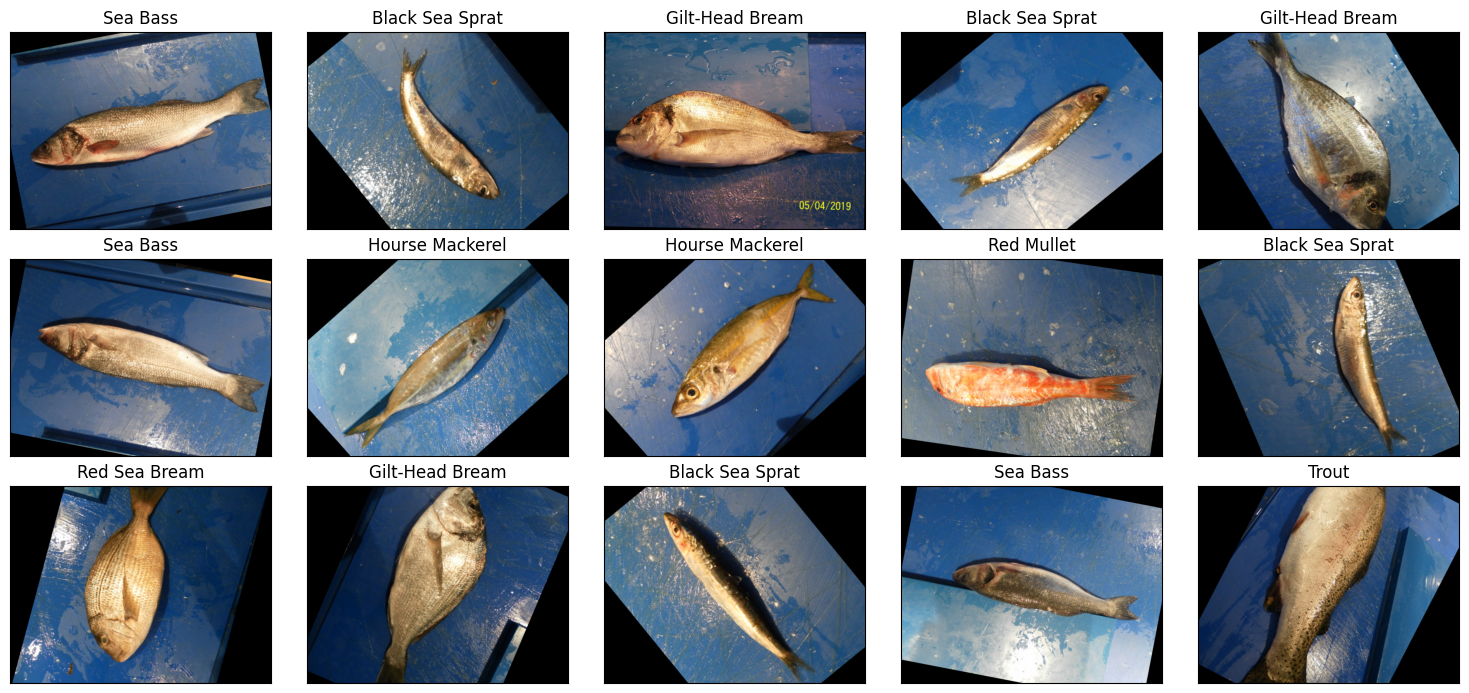

In [81]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

# 3. Load the Images with a generator<a class="anchor" id="3"></a>

In [82]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [83]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [84]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.


Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [85]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# 4. Train the model<a class="anchor" id="4"></a>

In [86]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50


/home/anhcbt/FishClassify/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.8583 - loss: 0.4691 - val_accuracy: 0.9944 - val_loss: 0.0196
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 73s 352ms/step - accuracy: 0.9975 - loss: 0.0119 - val_accuracy: 0.9951 - val_loss: 0.0114
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 76s 368ms/step - accuracy: 0.9984 - loss: 0.0083 - val_accuracy: 0.9981 - val_loss: 0.0041
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 75s 360ms/step - accuracy: 1.0000 - loss: 6.3507e-04 - val_accuracy: 0.9988 - val_loss: 0.0035
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 76s 369ms/step - accuracy: 1.0000 - loss: 3.2574e-04 - val_accuracy: 0.9988 - val_loss: 0.0027
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 75s 360ms/step - accuracy: 1.0000 - loss: 2.2825e-04 - val_accuracy: 0.9994 - val_loss: 0.0022
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 74s 357ms/step - accuracy: 1.0000 - loss: 1.6564e-04 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 73s 352ms/step - accuracy: 1.0000 - lo

In [87]:
# Lưu mô hình vào file 'fish_classifier_model.h5'
model.save('fish_classifier_model.h5')

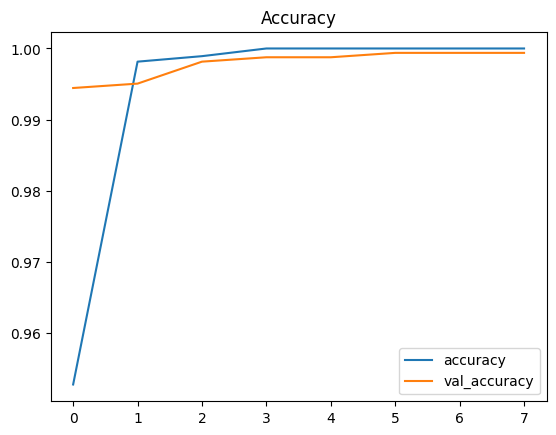

In [88]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

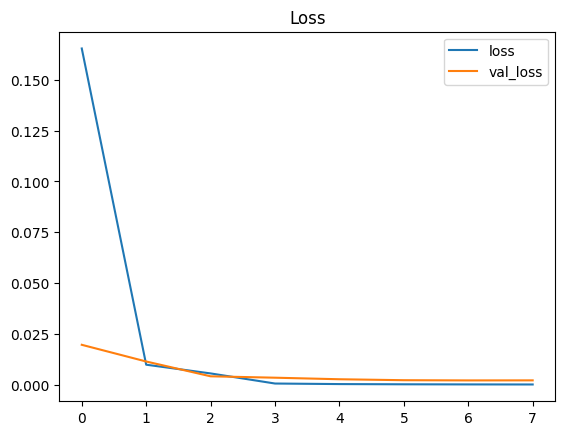

In [89]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 5. Visualize the result<a class="anchor" id="5"></a>

In [90]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/home/anhcbt/FishClassify/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.00217
Test Accuracy: 100.00%


In [99]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step
[0 3 3 0 3 0 5 2 7 5 2 8 6 5 1 4 3 6 2 4 1 2 2 6 0 6 5 2 2 4 0 3 2 4 4 7 6
 1 7 4 6 3 3 4 1 0 7 3 0 7 8 3 1 3 4 7 7 0 7 0 4 2 4 7 1 2 1 2 4 7 5 3 1 1
 5 1 2 6 0 4 1 6 5 1 7 6 3 8 3 4 7 0 0 4 2 4 4 8 2 6 3 8 6 2 0 4 3 7 3 6 8
 7 8 8 2 6 6 8 8 4 1 4 7 8 1 0 1 7 4 8 5 4 8 3 7 3 6 6 7 5 1 1 0 5 3 6 4 3
 1 3 6 1 0 1 8 0 6 0 2 3 6 7 1 8 2 0 4 3 4 0 7 8 4 6 1 7 6 2 1 6 0 3 2 3 3
 5 6 6 2 8 3 2 3 3 2 4 5 6 4 6 0 1 7 8 6 4 3 2 8 2 8 5 3 8 4 3 1 0 2 2 5 5
 3 0 8 1 5 8 7 2 1 8 6 2 4 5 4 3 5 4 8 0 7 5 3 4 4 6 2 4 3 3 2 8 2 5 0 2 5
 4 0 5 7 6 0 3 7 6 5 7 6 0 0 6 1 1 5 8 8 2 0 0 8 1 6 5 7 4 5 3 7 2 3 5 4 0
 8 6 5 2 5 3 4 3 2 5 8 6 0 8 4 8 2 5 4 4 6 6 5 5 3 3 6 6 2 8 7 3 7 8 0 2 6
 4 1 3 2 2 0 3 0 0 3 2 1 3 3 5 3 1 1 4 8 2 1 6 8 2 6 4 4 6 6 3 8 4 6 7 2 1
 5 3 7 5 5 2 5 5 1 0 8 1 8 0 6 4 5 3 8 5 6 5 2 8 4 3 7 7 4 6 8 7 5 6 1 8 1
 7 6 4 1 8 3 3 2 6 5 4 6 3 0 6 4 2 3 7 8 5 3 3 6 5 8 4 8 7 7 5 5 5 8 1 4 4
 2 0 2 8 5 7 1 3 0 2 1 4 2 5 6 4 7 7 1 0 5 8 7 7 7 0 8 2 4 

In [92]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        89
   Gilt-Head Bream       1.00      1.00      1.00        96
   Hourse Mackerel       1.00      1.00      1.00       109
        Red Mullet       1.00      1.00      1.00       112
     Red Sea Bream       1.00      1.00      1.00        94
          Sea Bass       1.00      1.00      1.00       107
            Shrimp       1.00      1.00      1.00       106
Striped Red Mullet       1.00      1.00      1.00        90
             Trout       1.00      1.00      1.00        97

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



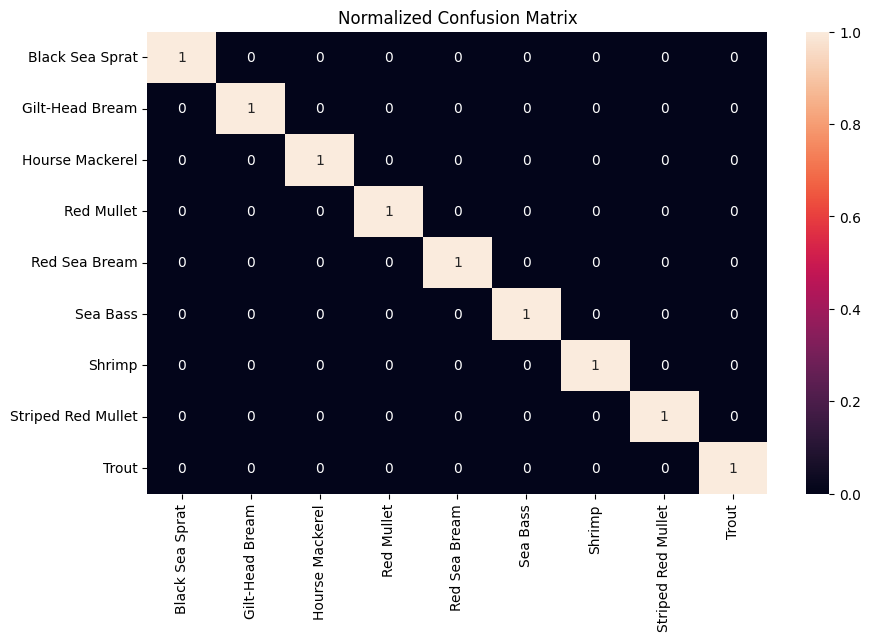

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## Examples of prediction

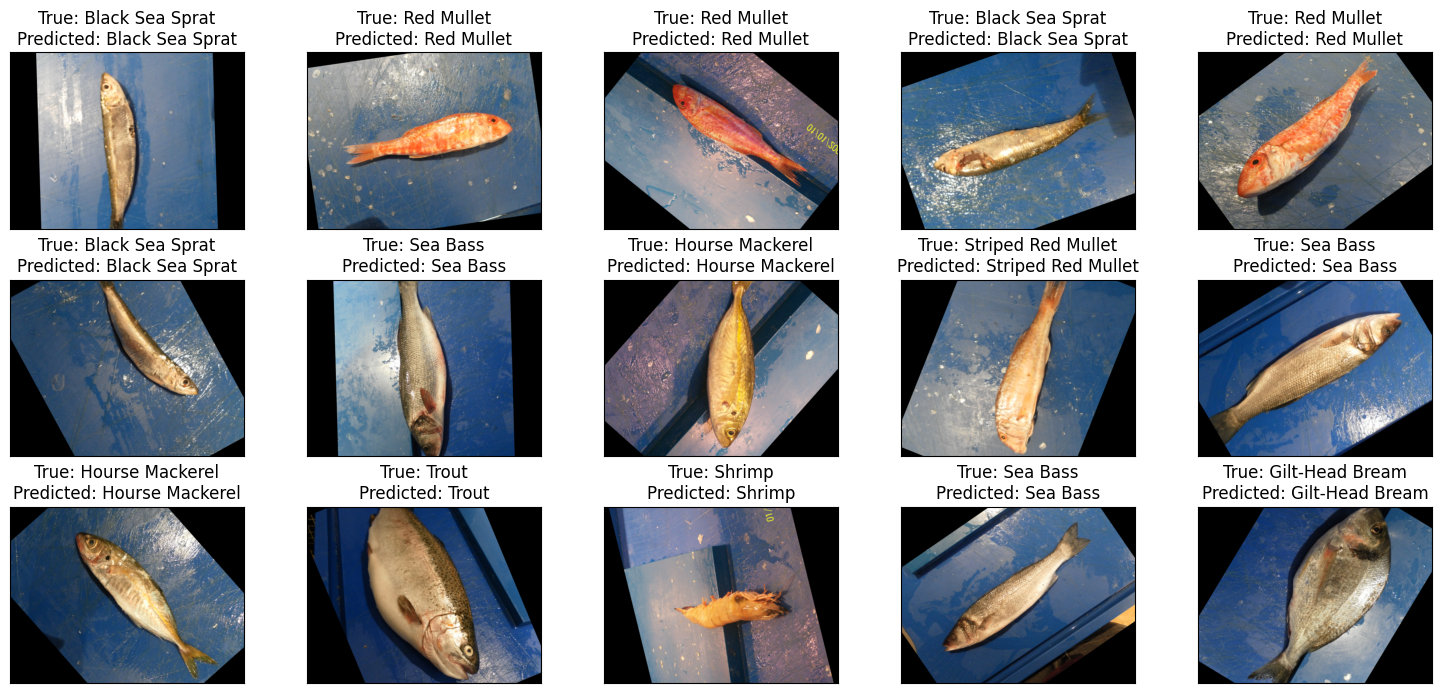

In [94]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 6. Class activation heatmap for image classification<a class="anchor" id="6"></a>
## Grad-CAM class activation visualization
*Code adapted from keras.io*

In [95]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

/tmp/ipykernel_402358/359930144.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


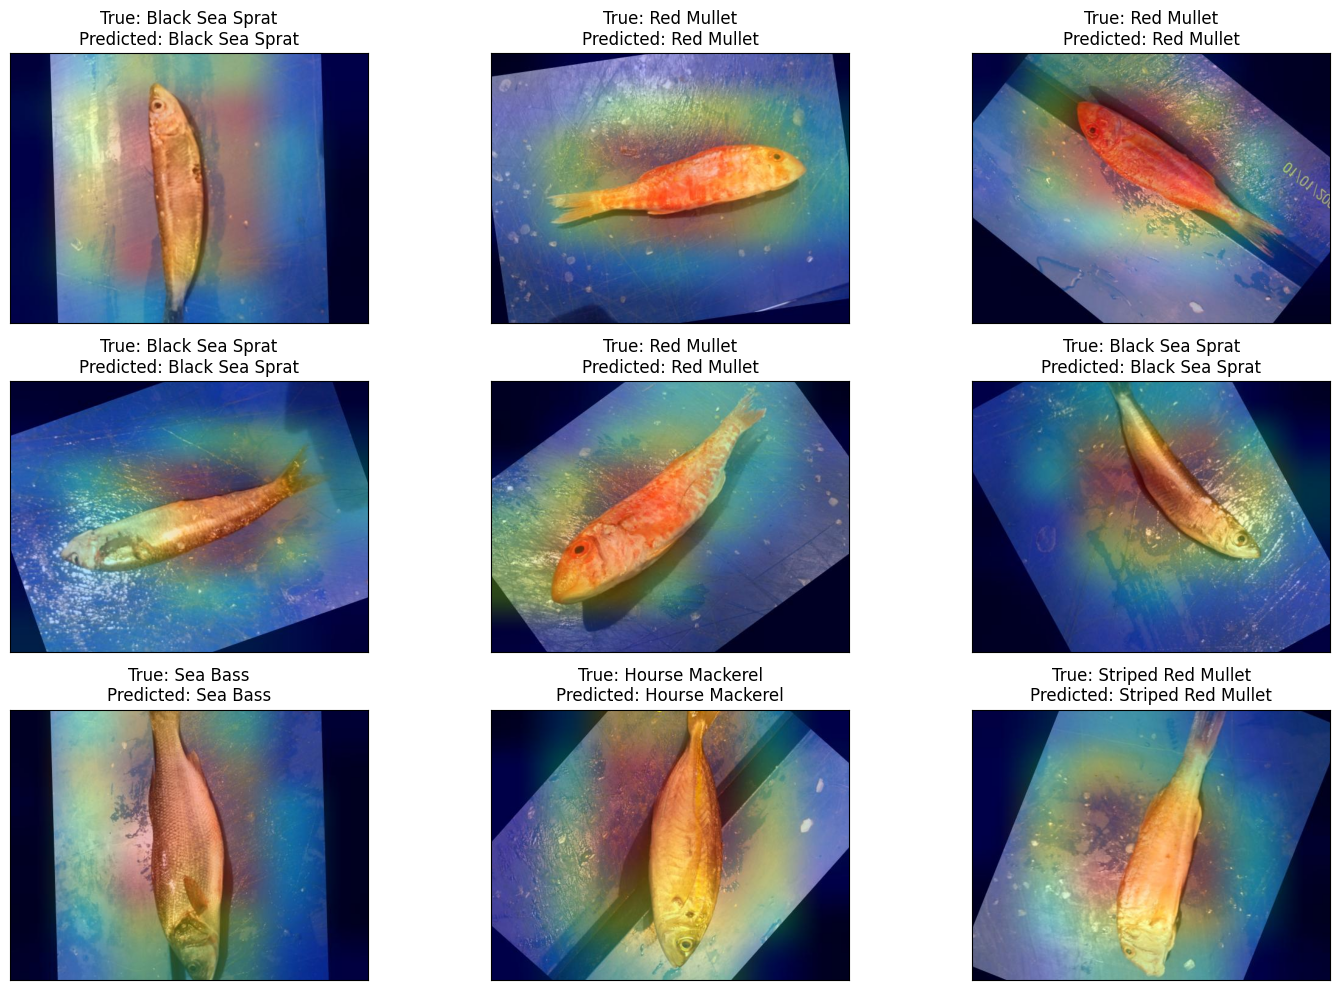

In [96]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()